<a href="https://colab.research.google.com/github/DanielMartinAlarcon/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [4]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [5]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [6]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=99.95285631147598, mobile=True), User(purchased=True, time_on_site=155.16533173785723, mobile=True), User(purchased=True, time_on_site=206.29154094088605, mobile=True), User(purchased=True, time_on_site=277.520768346148, mobile=True), User(purchased=False, time_on_site=501.0022290524834, mobile=False), User(purchased=False, time_on_site=104.78306219986125, mobile=True), User(purchased=False, time_on_site=197.36154680722055, mobile=True), User(purchased=False, time_on_site=24.36332012125355, mobile=False), User(purchased=False, time_on_site=237.704025283784, mobile=True), User(purchased=True, time_on_site=130.34523558540923, mobile=True)]


In [7]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,99.952856,True
1,True,155.165332,True
2,True,206.291541,True
3,True,277.520768,True
4,False,501.002229,False


In [8]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.234433214345272,7.721960300753299,7.860486093988014,8.180438494957118,8.234841614664749,8.251180542785272,8.56975242252036,8.82225640236471,9.76463980084873,10.023225326465397,...,585.4158548211036,588.8768686556706,589.5942590277832,590.1044978363356,592.4950000455494,592.4963764376632,593.7630306849239,594.0469236430073,594.8826416010085,598.809831063473
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.641, 123.95]","(123.95, 242.665]","(242.665, 361.38]","(361.38, 480.095]","(480.095, 598.81]"
purchased,,,,,
False,291,281,171,33,43
True,64,80,28,4,5


In [10]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.641, 123.95]","(123.95, 242.665]","(242.665, 361.38]","(361.38, 480.095]","(480.095, 598.81]"
purchased,,,,,
False,0.819718,0.778393,0.859296,0.891892,0.895833
True,0.180282,0.221607,0.140704,0.108108,0.104167


In [11]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.908,0.789333
True,0.092,0.210667


In [12]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab([user_data['purchased'], time_bins], user_data['mobile'], 
            normalize='columns')

mobile                       False     True 
purchased time_on_site                      
False     (4.641, 123.95]    0.220  0.314667
          (123.95, 242.665]  0.180  0.314667
          (242.665, 361.38]  0.204  0.160000
          (361.38, 480.095]  0.132  0.000000
          (480.095, 598.81]  0.172  0.000000
True      (4.641, 123.95]    0.012  0.081333
          (123.95, 242.665]  0.020  0.100000
          (242.665, 361.38]  0.024  0.029333
          (361.38, 480.095]  0.016  0.000000
          (480.095, 598.81]  0.020  0.000000

In [16]:
data = user_data.groupby('mobile')
data.head()

,purchased,time_on_site,mobile
0,False,99.952856,True
1,True,155.165332,True
2,True,206.291541,True
3,True,277.520768,True
4,False,501.002229,False
5,False,104.783062,True
7,False,24.363320,False
10,False,548.055887,False
11,False,336.872098,False
15,False,41.936689,False


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [32]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Upgrade to the latest Seaborn to make sure that scatterplots exist.
!pip install seaborn --upgrade

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

data_url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv'
persons = pd.read_csv(data_url)

# The first column is unnamed, so I rewrite the column names to call it 'ID'
persons.columns = ['ID', 'age', 'weight', 'exercise_time']
persons.head()

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


,ID,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


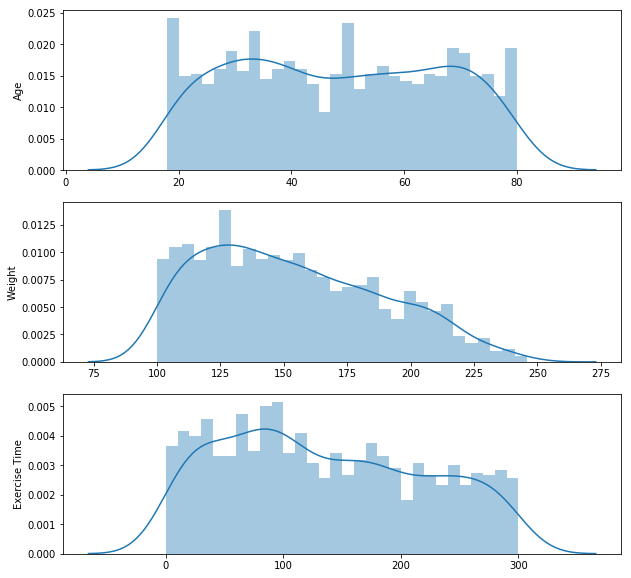

In [33]:
'''
Let's see what those variables look like on their own.
'''

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

sns.distplot(persons['age'], bins=30, ax=ax1, axlabel=False);
sns.distplot(persons['weight'], bins=30, ax=ax2, axlabel=False);
sns.distplot(persons['exercise_time'], bins=30, ax=ax3, axlabel=False);

ax1.set_ylabel("Age");
ax2.set_ylabel("Weight");
ax3.set_ylabel("Exercise Time");

Alright, looks like Age is truncated at the ends, weight is truncated at the bottom, and Exercise time is truncated at the top.  Also, Age looks uniformly distributed while low weights and exercise times predominate.  My first guess is that exercise time is a function of both.  Let's use scatterplots to see some pairwise relationships.

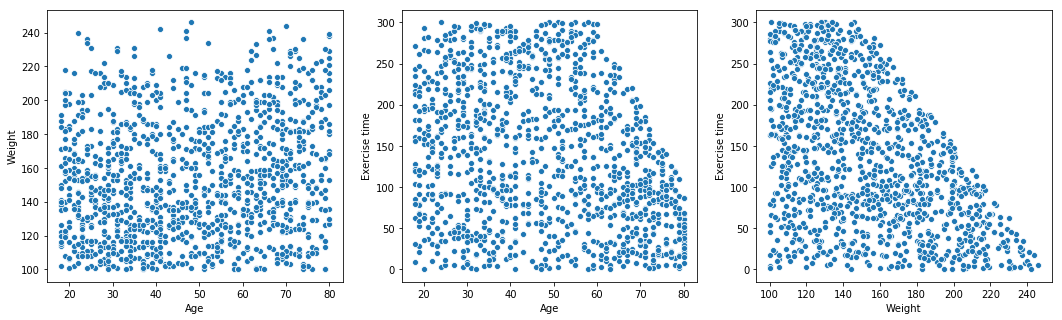

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))


sns.scatterplot(persons['age'], persons['weight'], ax=ax1);
ax1.set_xlabel("Age");
ax1.set_ylabel("Weight");

sns.scatterplot(persons['age'], persons['exercise_time'], ax=ax2);
ax2.set_xlabel("Age");
ax2.set_ylabel("Exercise time");

sns.scatterplot(persons['weight'], persons['exercise_time'], ax=ax3);
ax3.set_xlabel("Weight");
ax3.set_ylabel("Exercise time");


What the...??  

Alright, there's definitely something going on here.  While weight seems to be uniformly distributed among age groups, exercise time starts decreasing linearly after 60 years and after 150 lbs.  Clearly, I need to look at exercise time as a function of both the other two variables at once. Time for a heatmap.

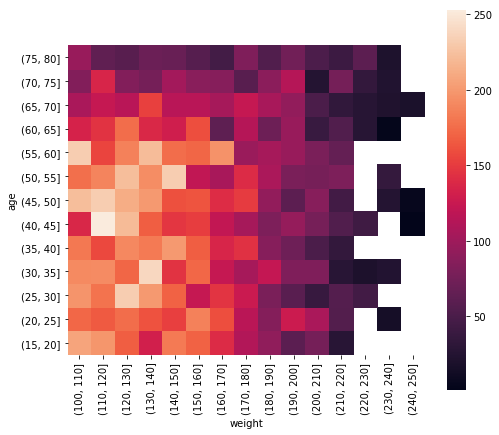

In [66]:
'''
Age and weight are binned so that we can aggregate exercise times within 
each combination of bins and hopefully see a pattern.

'''
age_bins = pd.cut(persons.age, np.arange(15,85,5))
weight_bins = pd.cut(persons.weight, np.arange(100,260,10))

fig, ax1 = plt.subplots(1, figsize=(8, 7))

sns.heatmap(pd.crosstab(age_bins, weight_bins, values=persons.exercise_time,
                        aggfunc='mean'), ax=ax1, square=True);
ax1.invert_yaxis()


Alright, we basically see the same pattern we'd expect from the earlier graphs, but it's actually LESS clear where the cutoffs are from the heatmap.  The really clear relationships are visible only in the pairwise graphs earlier.  

Someone pointed out that weight could be the actual dependent variable here, not exercise time.  So does anything clearer show up if we graph weights in terms of the other two variables instead?



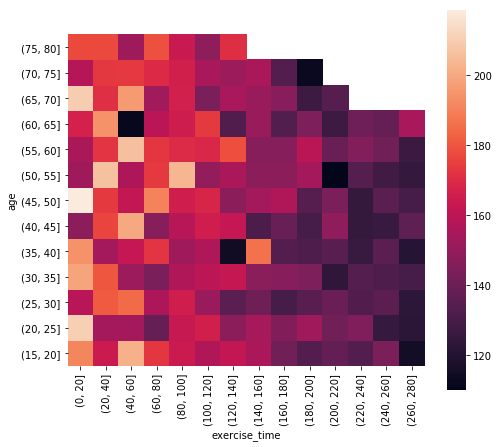

In [68]:
age_bins = pd.cut(persons.age, np.arange(15,85,5))
weight_bins = pd.cut(persons.weight, np.arange(100,260,10))
exercise_bins = pd.cut(persons.exercise_time, np.arange(0,300,20))

fig, ax1 = plt.subplots(1, figsize=(8, 7))

sns.heatmap(pd.crosstab(age_bins, exercise_bins, values=persons.weight,
                        aggfunc='mean'), ax=ax1, square=True);
ax1.invert_yaxis()

Not particularly.  This is even less clear than the previous case.  Alright, what if I tried binning by age, and looking for relationships between weight and exercise time within each of those age bins?  I create two bins right around 60, where age seems to start having an effect.




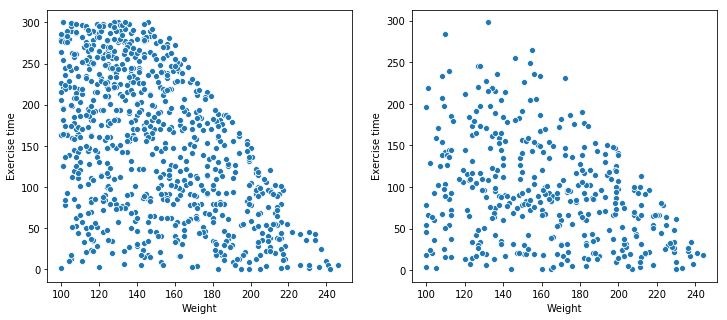

In [86]:
young = persons[persons['age'] < 60]
old = persons[persons['age'] >= 60]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(young['weight'], young['exercise_time'], ax=ax1);
ax1.set_xlabel("Weight");
ax1.set_ylabel("Exercise time");

sns.scatterplot(old['weight'], old['exercise_time'], ax=ax2);
ax2.set_xlabel("Weight");
ax2.set_ylabel("Exercise time");



Dammit, those relationships still look the same, just sparser.  Someone else on Slack did the same thing but for several different age bins, and the relationship looks the same in all cases. 

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

All the variables are continuous. Age has to be independent, but it's a bit of a toss-up whether weight or exercise time is really dependent on the other.

2.  What are the relationships between the variables?

Age and weight don't seem to be related to each other at all.  Exercise time has a complex relationship with both age and weight. In both cases, it varies randomly between the minimum and maximum value (of exercise time) until a certain threshold of age or weight. After that threshold, the maximum value decreases linearly.  I spent a lot of time trying to think of a graph that would tease out a relationship between these two cliffs, but I couldn't think of any.  I must be thinking about this wrong somehow.

3.  Which relationships are "real", and which spurious?

Age <> weight seems spurious, but exercise time varies as a function of both age and weight (as shown clearly by the heatmap.)

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)